In [1]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


now we need a strategy to _tokenize_ the input text

this means converting the raw text as a string to some sequence of integers according to some notebook/vocabulary of possible elements

since its a character level language model, we are baiscally just converting characters to integers

In [5]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

#here is an example
print(encode("We are citizens"))
print(decode(encode("We are citizens")))

[35, 43, 1, 39, 56, 43, 1, 41, 47, 58, 47, 64, 43, 52, 57]
We are citizens


many other "schemas" that people have come up with to tokenize

google uses sentencepiece which encodes text into integers but in a different way and using different vocabulary. It is also uses subword units which means that they are not including entire words but not just characters

gpt also uses subword units. this is standard in practice

we are using character level tokenizer for reference

In [6]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)

torch.Size([1115394]) torch.int64


In [7]:
n = int(0.9 * len(data)) #10% val 90% train
train_data = data[:n]
val_data = data[n:]

In [8]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [9]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


We are using from one to 8 characters of context in order to predict the next character

Because we have gpus, we can parallel process using multiple chunks

In [10]:
torch.manual_seed(1337)
batch_size = 4 # how many sequences are we looking at in parallel
block_size = 8 # what is the maximum context length

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('-----')

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
-----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

We will use xb as an input to the transformer

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__() 
        # we are having each token read off the logits from the next token using lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) #(B, T, C)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)
idx = torch.zeros((1, 1), dtype = torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


Here we are implementing pytorch module directly\
when the input and targets go to forward, we take index and go to token embedding table\
embedding is a very thin wrapper which has corresponding embedding for each character which is represented by the row idx\
then this is turned into a tensor which is in the dimensions of batch by time by channel


- Learns to predict the next character based only on the current one.

- Uses an embedding layer as the only learnable layer.

- Trains with cross-entropy loss.

- Can generate new sequences by sampling from the predicted probability distribution.

In [12]:
# lets train the model so its not as random
#create a pytorch optimizer (in the makemore we used gradient descent SGD)
# now we are using adamw
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3) #typical is 3e-4 but 
# smaller models allow for higher learning rates

In [13]:
batch_size = 32
for steps in range(10000):
    
    xb, yb = get_batch('train')
    
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
print(loss.item())

2.5727508068084717


In [14]:
print(decode(m.generate(idx, max_new_tokens=400)[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenou


This is the simplest possible model. But we are only given a context of one character so we cannot expect much.

So now the tokens need to start talking to each other in order to get better context to make better predictions. This is how we will kick off the transformer

# I am moving to vs code :thumbs_up:


....


Never mind, I cannot ssh directly to a gpu 

In [15]:
%run bigrams.py

step 0: train loss 4.7203, val loss 4.7136
step 1000: train loss 2.4885, val loss 2.5195
step 2000: train loss 2.4712, val loss 2.4916
step 3000: train loss 2.4615, val loss 2.4866
step 4000: train loss 2.4592, val loss 2.4833
step 5000: train loss 2.4577, val loss 2.4888
step 6000: train loss 2.4528, val loss 2.4919
step 7000: train loss 2.4609, val loss 2.4899
step 8000: train loss 2.4538, val loss 2.4855
step 9000: train loss 2.4604, val loss 2.4947
2.4175219535827637



CExthy brid owindakis s, bt madiset bobe d e.
S:
O:
IS:
Falatanss:
Wanthar u qur, vet?
F dilasoate awice my.
Whastarom oroup
Yowhthetof isth ble mil ndill, ath iree senghin lat Heridrovets, and Win nghire yombousel lind me l.
MAshe ce hiry:
Supr aisspllw y.
Hurindu noroopetelaves
MP:

Pl, d mothakleo Windo whth eisbyo wie m dourive ce hidend t so mower; te

AN ad nterupt f s ar iris! m:

Thiny aleronth, af Pre?

WISo myr f-bube!
KENoby ak
Sadsal thes ghesthidin cour ay aney Iry ts I fr y ce wi


# The mathematical trick used in self attention

In [16]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch size, sequence len, # of channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

The simplest way to communicate with all previous tokens is averaging the channels from 1st, 2nd, 3rd, 4th if you are the 5th token

now we are just getting the average 

In [17]:
xbow = torch.zeros((B, T, C)) #bow = bag of words
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t, C)
        xbow[b, t] = torch.mean(xprev, 0)

This is a toy version of causal self-attention where each token only has access to previous tokens. Basically I'm simulating:

    "What if each token just looked at the average of everything before it?"

In [18]:
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a /= torch.sum(a, 1, keepdim=True)
b = torch. randint(0,10,(3,2)).float()
c = a @ b
print(a)
print(b)
print(c)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


we can sum these rows in an incremental fashion by taking advantage of matmul and then normalize them

In [19]:
#v2
wei = torch.tril(torch.ones(T, T))
wei /= wei.sum(1, keepdim=True)
#wei = wei.unsqueeze(0).expand(B, -1, -1)
xbow2 = wei @ x #(B, T, T) , (B, T, C)
#now xbow and xbow2 are identical
# print(torch.allclose(xbow, xbow2, atol=1e-6))
# print(xbow[0])
# xbow2[0]

In [20]:
# version 3: using softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow2, xbow3)

True

Bigram = pure counting + direct prediction.

this next version = learns feature representations, useful for adding Transformer blocks (self-attention, etc.) later.

Position embeddings allow the model to distinguish the order of words, unlike bigram models which treat "AB" and "BA" similarly.

In [27]:
# version 4: with self attention
torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2, -1) # (B, T, 16), (B, 16, T) -> (B, T, T)
tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T, T)) 
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
# out = wei @ x

out.shape

torch.Size([4, 8, 32])

I want to gather information from the pass in a self independent way. \
This is what self attention solves \
for example, if i am a vowel, I want certain consonant info to flow directly to me \
we should dot product the keys and the queries 


In [29]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

In self-attention, each token (or “node”) starts with a vector (the embedding or hidden state), and then updates itself by aggregating vectors from other tokens — but not uniformly: it aggregates weighted information, where the weights are learned and content-dependent (based on similarity of queries and keys). \
This is a message-passing system:
- Tokens send information.
- The receiving token decides how much of each message to "listen to".

Why is this effective?
- It lets every token dynamically decide what parts of the sequence are relevant to it.
- This is unlike convolution, where information only flows from a fixed local neighborhood.

no notion of space, attention simply acts as a set of vectors in this graph and thats why we need to give them a positional understanding.
Self-attention operates on sets of vectors — it doesn’t inherently understand order or position.
- If you shuffle the input sequence, attention will still work the same way.
- But language and sequences do have order — “cat sat on mat” ≠ “mat sat on cat”.

Solution: Positional Encodings
- You inject information about position into the vectors — e.g., add sinusoidal or learned positional vectors to the token embeddings.
- This gives the model a sense of order, so that even though attention is pairwise and global, it can still respect sequence structure.

Convolutions are inherently local and spatial:
- They process a fixed-size window (e.g., 3×3), sliding across the input.
- They are position-aware by design — because the kernel weights are tied to relative position.

Attention is global and content-based:
- Every token can attend to every other token, regardless of position.
- Position must be explicitly added, or it’s lost.



More notes (from the video)
- Attention is a communication mechanism. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other 
- In an "encoder" attention block just delete the single line that does masking with tril, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides wei by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax wil stay diffuse and not saturate too much. Illustration below \
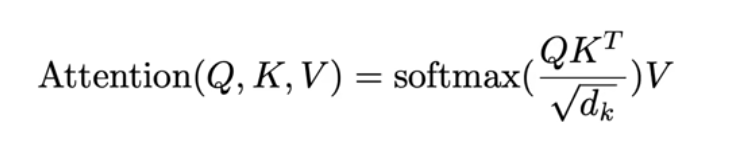

In [34]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [35]:
k.var()

tensor(1.0700)

In [36]:
q.var()

tensor(0.9006)

In [37]:
wei.var()

tensor(1.1277)

In [38]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [39]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) * 8, dim=-1)

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

softmax sharpens towards the max very quickly, we dont want nodes to all aggregate to a single node, especially @ initialization

In [46]:
%run single_head.py

step 0: train loss 4.1852, val loss 4.1903
step 500: train loss 2.6966, val loss 2.7139
step 1000: train loss 2.5196, val loss 2.5317
step 1500: train loss 2.4770, val loss 2.4827
step 2000: train loss 2.4425, val loss 2.4527
step 2500: train loss 2.4274, val loss 2.4433
step 3000: train loss 2.4138, val loss 2.4341
step 3500: train loss 2.3962, val loss 2.4220
step 4000: train loss 2.4037, val loss 2.3989
step 4500: train loss 2.3985, val loss 2.4087
2.5493083000183105

Whent iknt,
Thowi, ht son, bth

Hiset bobe ale.
S:
O-' st dalilanss:
Want he us hathe.
War dilas ate awice my.

HDET:
ANGo oug
Yowhavetof is he ot mil ndill, aes iree sen cie lat Herid ovets, and Win ngarigoerabous lelind peal.
-hule onchiry ptugr aiss hew ye wllinde norod atelaves
Momy yowod mothake ont-wou whth eiiby we ati dourive wee, ired thoouso er; th
To kad nteruptef so;
ARID Wam:
ENGCI inleront ffaf Pre?

Wh om.

He-
LIERCKENIGUICar adsal aces ard thinin cour ay aney Iry ts I fr af ve y


loss is a little better but still bad

next up is multi-head attention, applying multiple layers of attention (kind of like a group convolution)\
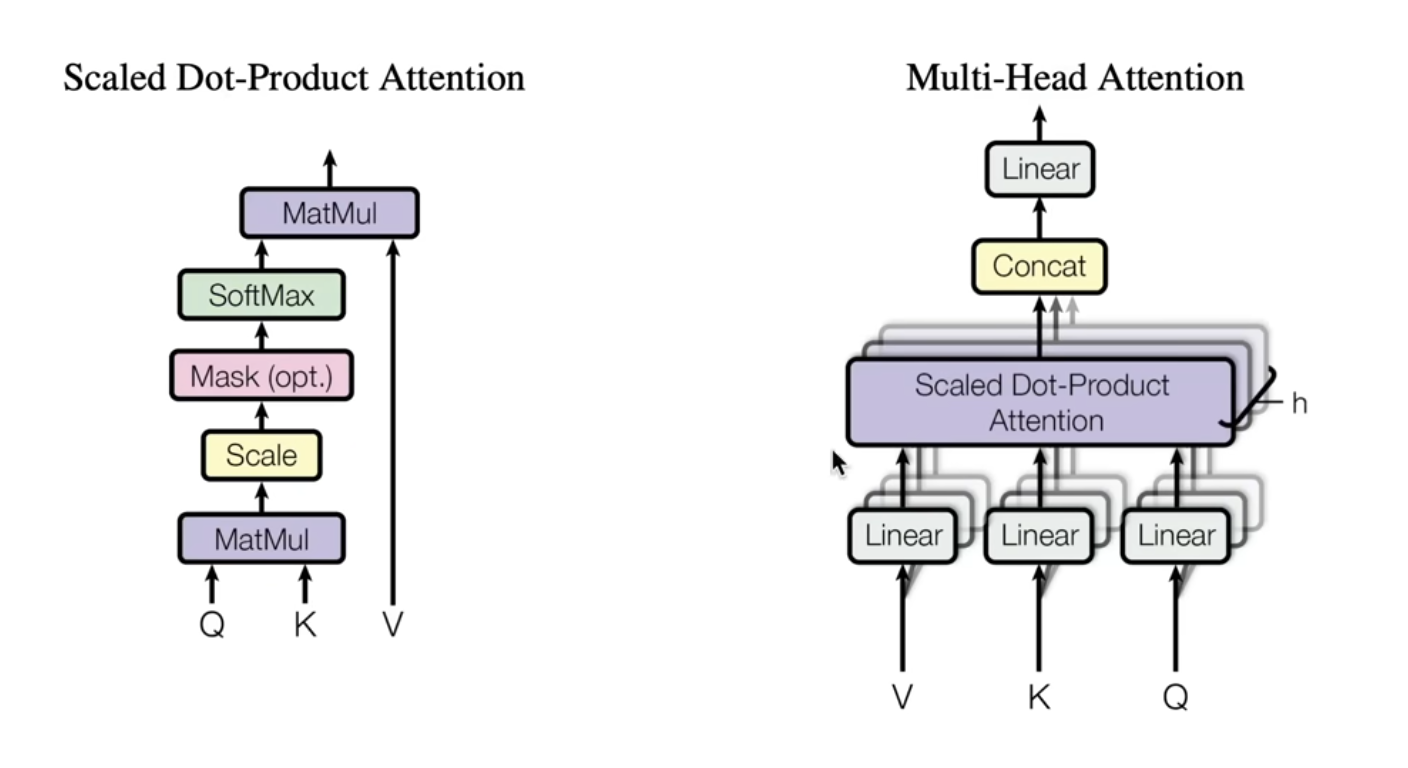

In [48]:
%run multi_head.py

step 0: train loss 4.2103, val loss 4.2105
step 500: train loss 2.6623, val loss 2.6749
step 1000: train loss 2.4980, val loss 2.5083
step 1500: train loss 2.4299, val loss 2.4370
step 2000: train loss 2.3762, val loss 2.3869
step 2500: train loss 2.3449, val loss 2.3578
step 3000: train loss 2.3183, val loss 2.3386
step 3500: train loss 2.2944, val loss 2.3214
step 4000: train loss 2.2916, val loss 2.2893
step 4500: train loss 2.2772, val loss 2.2895
2.4332597255706787

Whent if bridcowilen is byert madiset bobe uge.
SGhOnd my dalleauss:
Warth foulque, vet?
Wedtlas anes wicr my.

HDY'n om oroug
Yowts, tof is heir thil; dill, aes isee sen cin lat Het drov the and Wing.

DWAFerace!
 leland teall lis my ne myy prugh aissthe, ye wlemake normopeeelaves
Mom.

Whod mothake ont---An bre evibre wor modourive weeshirecs poor gier; thure knd nonrupt for ar igre! mef thre inledo the af Pre?

WISo myay I sup!

Widby aar adsal the E'd stevein cou aly andy Iry to I frouf voul


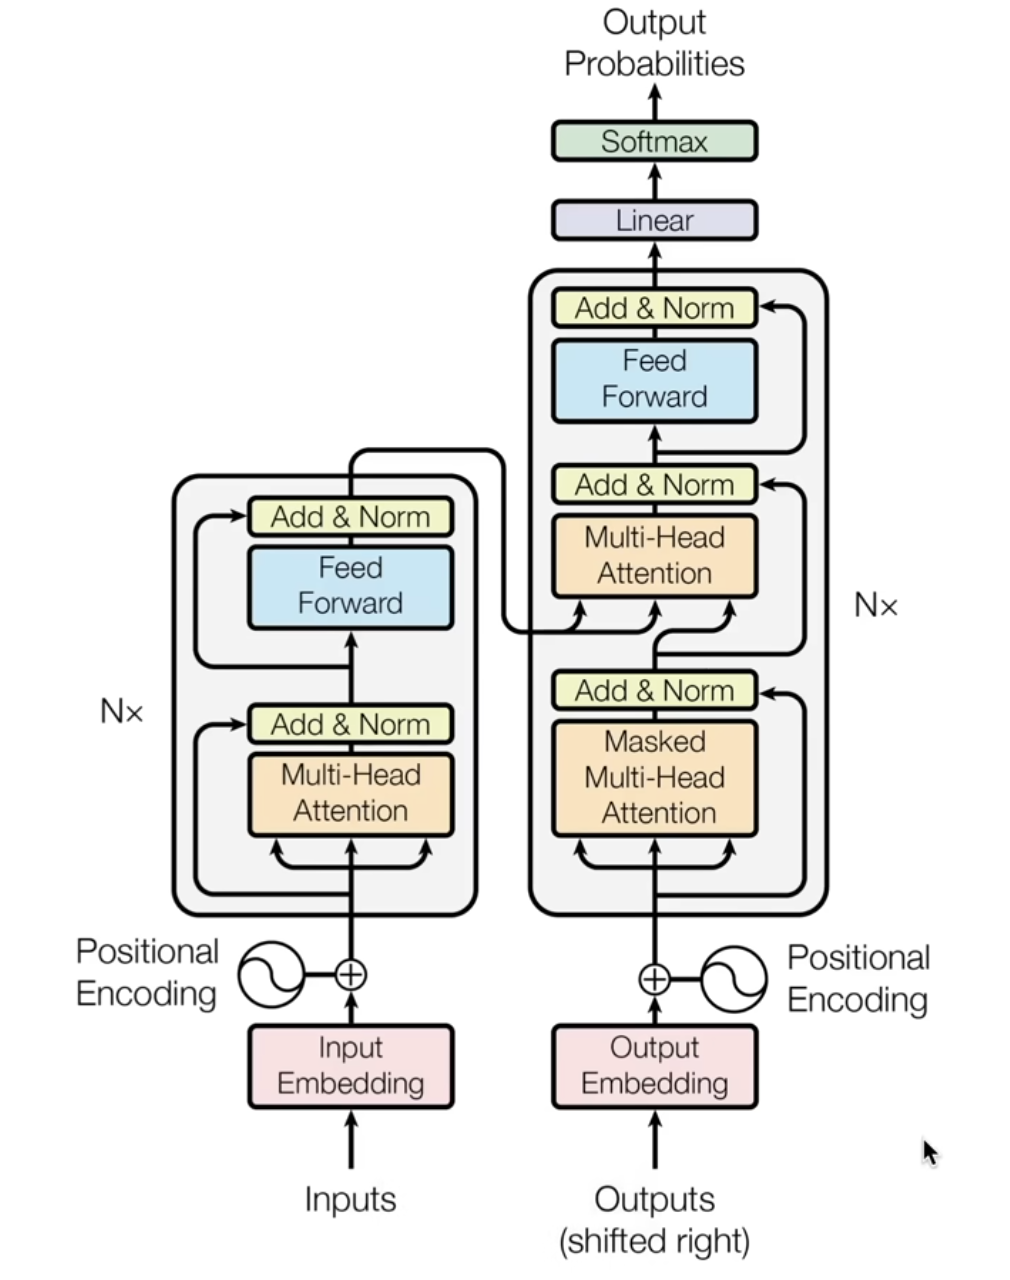

we still need to add the feedforward part, and it gets iterated over and over again
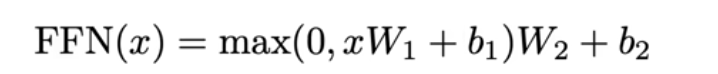
interspersing communication with the computation

In [51]:
%run feedforward.py

step 0: train loss 4.2073, val loss 4.2036
step 500: train loss 3.1008, val loss 3.1005
step 1000: train loss 2.7012, val loss 2.6980
step 1500: train loss 2.5765, val loss 2.5648
step 2000: train loss 2.4836, val loss 2.5010
step 2500: train loss 2.4441, val loss 2.4400
step 3000: train loss 2.3978, val loss 2.4221
step 3500: train loss 2.3917, val loss 2.4085
step 4000: train loss 2.3800, val loss 2.3693
step 4500: train loss 2.3355, val loss 2.3516
2.2779414653778076

And thef bridcowd,
The loferte
baisen bobe to tanthend my dalceanss:
Want he us he hent?
Fedtlasoate awice my thans arom onou:
Yow sortof is he cevasl; dill, beg iree sengcin latismaclrov the and the non onderjeses lelind teald thule cechery pruge aiss hewty. Hunt, uf youd atelgods
Aom
the the to akleo Winso when eiiby wener, dourive cend ime sto-ocom enxorg
Te kadd thrugtef sor; igk to shit fey ale oft tisf Pordd my omethand sok!

Tiy fis:
Arosalcuces ghe thidin couk aar tey Iry to chan you!

J


after adding a simple feed forward layer and adding blocks to intersperse communication and computation, we are still not getting a very good result. this is because now we have a very deep neural net, which is harder to optimize. now we can try adding "skip connections" or residual connections. Basically we are... \
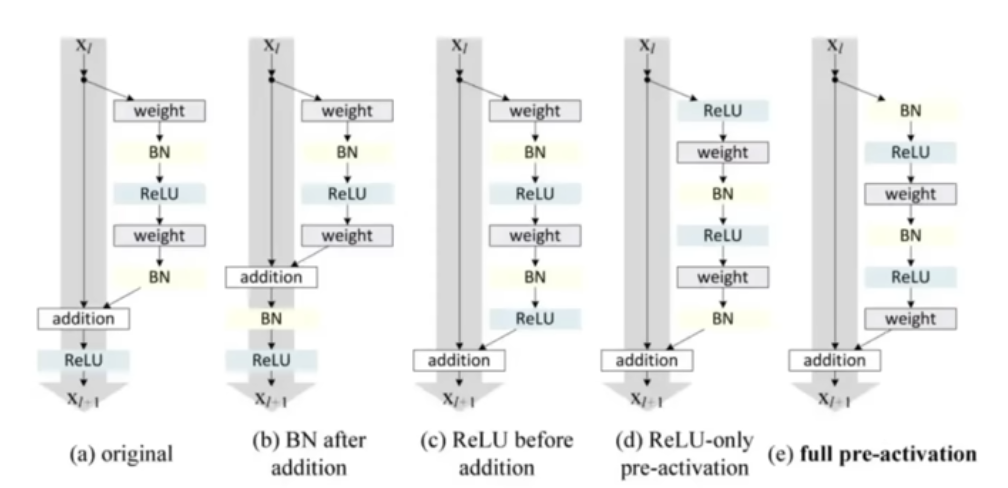 

basically we are adding a gradient highway to directly impact the weights with blocks kicking in over time

- Deeper networks usually suffer from vanishing gradients and degradation (where adding more layers makes performance worse).
- Residual connections bypass layers, letting the gradient flow directly back to earlier layers — this helps train deep networks effectively.
- They let layers focus on learning small adjustments rather than the full transformation → making deeper stacks of layers both trainable and useful.

In [71]:
%run residual_connections.py

step 0: train loss 4.2136, val loss 4.2135
step 500: train loss 2.3916, val loss 2.3891
step 1000: train loss 2.2687, val loss 2.2675
step 1500: train loss 2.1831, val loss 2.2083
step 2000: train loss 2.1367, val loss 2.1683
step 2500: train loss 2.0919, val loss 2.1429
step 3000: train loss 2.0665, val loss 2.1351
step 3500: train loss 2.0552, val loss 2.1119
step 4000: train loss 2.0222, val loss 2.0964
step 4500: train loss 1.9996, val loss 2.0934
2.003934383392334

When?
Dear,
Thowill to layes that sellander werave Our my dagalaus bardith foulque, Get?
Feethat ane away, my fef'll comzormune own Lotoffing I me milled;
Whoues if enten cin;
Stistlidrev the and the now on that spelf in ame littius wouch by prughtiess hiw you lord.
In Booke blaves
Morthy would thake on in on her eights the most this cees,
Tell poothere for unds and thrupt for arm;
The muft wity ale of whis dare?

KIS? Vort I sub!
Atied is wards.
Wices and thisin cous ay and
Hiry to chan the!
My


In [68]:
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
    def __call__(self, x):
        xmean = x.mean(1, keepdim=True) # batch mean (use 0 for batch norm, 1 for layernorm)
        xvar = x.var(1, keepdim=True) # batch variance (0 for bn, 1 for ln)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)
x = module(x)
x.shape

torch.Size([32, 100])

In [69]:
x[:, 0].mean(), x[:, 0].std() # This is normalized in batchnorm

(tensor(0.1469), tensor(0.8803))

In [70]:
x[0, :].mean(), x[0, :].std() # this is normalized in layernorm

(tensor(-9.5367e-09), tensor(1.0000))

Now to implement layer norm, instead of normalizing the columns, we normalize the rows. Very simple :D \
When switching: 
- LayerNorm doesn't care about the batch dimension at all.
- It normalizes within each sample, across features.
- So training and inference behave identically — no need for running_mean or momentum.\
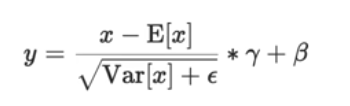

Unlike Batch Normalization and Instance Normalization, which applies scalar scale and bias for each entire
channel/plane with the affine option, Layer Normalization applies per-element scale and bias with
elementwise_affine.\
Although the paper diagram shows the add&norm after the multi-head attention, the difference is that now it is usually applied before 

In [ ]:
%run gpt.py

10.788929 M parameters
step 0: train loss 4.2221, val loss 4.2306
step 500: train loss 1.7547, val loss 1.9094
step 1000: train loss 1.3902, val loss 1.5968
step 1500: train loss 1.2648, val loss 1.5221
step 2000: train loss 1.1856, val loss 1.4968


In [76]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


That hand, e'er I hence it, on an inquter, to a
poison, or unluckily, and beat your poor,
wickably, as my looks, 'pardon-pahe.'

ANTIGHOMAS MOWBRAY:
No, no.

AUTOLYCUS:

CLARENCE:
O, dearly Isabel.

GLOUCESTER:

CAtESBY:
Greather, peace is abanished.

POMPEY:
Angelo, peace, but not this in requal us hate.

CAPULET:
Forbid say you, now, sir,
That shall be sudden. Hark:
Yes, boy, sir, hear youu the father trial!

Nurse:
Help, Grey! more wounds us here he rests;
I'll make aMargarder prison it, that


In [77]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


Of my try, that deads bear'd the earth irour lists,
There commonwith a rough ride grief;
With duty, mine own town gap one of the new dispatch
Within this tied rings; and do now it,
Son little short closed in my kindness,
Who beauty have been the immaginaces in our cause.

First Murderer:
But sheething on his own state and last, both weeps and well-stoned
When we was from his dead below.
Welcome, Clarence; be it in reason be broad,
Then that cloudy King Richard love atten?

MONTAGUE:
Upon thy dear as a kings, at home, brove poor:
Then pressn hath pierced out, which even hearts
Was not like unruly to court. Come, you husband.

GLOUCESTER:
My lord, be that Londoner shalt endows
His way it.

KING HENRY VI:
And that then I sail the befit modest lour,
Then it becomes it wear by advancement.

BUSHY:
You are conturbt more than than myself mortal:
Why foundly mother-speak and fast that to-day;
Who, then, our damned an out,
Durs, too false suspestition of the seky change;
For you.

First Keeper

In [78]:
estimate_loss()

{'train': tensor(0.8557), 'val': tensor(1.5707)}

{'train': tensor(0.8557), 'val': tensor(1.5707)}